## Installs

In [55]:
# Operational Packages
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import os
import zipfile
import shutil
import geopandas as gpd
from shapely.geometry import Polygon

# Directories
nb_dir = Path.cwd()
REPO_ROOT = nb_dir.parent
data_dir = REPO_ROOT / 'data/'
processed_dir = data_dir / 'processed/'
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))



In [56]:
# Unzip all Shapefiles
def unzip_to_folder(zip_path, extract_to):
    """
    Unzips a ZIP archive into a specified directory.
    """
    extract_to = Path(extract_to)
    extract_to.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)                  # Read SHP to destination folder

    macosx_folder = extract_to / '__MACOSX'
    if macosx_folder.exists():
        shutil.rmtree(macosx_folder)

In [57]:
zippaths = Path(data_dir/'raw/zips')                    # ZIPs folders
zipfolders = list(zippaths.glob('*.zip'))           # Select all .ZIP

for folder in zipfolders:
    unzip_to_folder(folder,processed_dir/'shapefiles'/str(folder.name)[:-4])    # Retain name indentity
    print(f'NBAC Wildfires Year: {(str(folder.name)[5:9])} Shapefiles opened')



NBAC Wildfires Year: 2021 Shapefiles opened
NBAC Wildfires Year: 2020 Shapefiles opened
NBAC Wildfires Year: 2018 Shapefiles opened
NBAC Wildfires Year: 2019 Shapefiles opened
NBAC Wildfires Year: 2022 Shapefiles opened
NBAC Wildfires Year: 2023 Shapefiles opened
NBAC Wildfires Year: 2024 Shapefiles opened


In [58]:
# Open all Shapefiles
all_gdfs = {}   # Store in dictionary

for folder in (processed_dir / "shapefiles").iterdir():
    if folder.is_dir():
        shp = next(folder.glob("*.shp"), None)
        if shp:
            name = folder.name
            all_gdfs[name] = gpd.read_file(shp)

# All dictionary keys
all_gdfs.keys()


dict_keys(['NBAC_2024_20250506', 'NBAC_2023_20250506', 'NBAC_2022_20250506', 'NBAC_2019_20250506', 'NBAC_2018_20250506', 'NBAC_2020_20250506', 'NBAC_2021_20250506'])

In [59]:
# Assess each shapefile's (key) column structure

# 1. Get union of all column names
all_cols = sorted(
    {col for gdf in all_gdfs.values() for col in gdf.columns}
)

# 2. Create a DataFrame of False
presence = pd.DataFrame(
    False,
    index=all_gdfs.keys(),
    columns=all_cols,
)

# 3. Mark columns that exist in each GeoDataFrame
for name, gdf in all_gdfs.items():
    presence.loc[name, gdf.columns] = True

presence


,ADJ_FLAG,ADJ_HA,ADMIN_AREA,AG_EDATE,AG_SDATE,BASRC,CAPDATE,FIRECAUS,FIREMAPM,FIREMAPS,...,HS_SDATE,NATPARK,NFIREID,POLY_HA,PRESCRIBED,Shape_Area,Shape_Leng,VERSION,YEAR,geometry
NBAC_2024_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2023_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2022_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2019_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2018_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2020_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
NBAC_2021_20250506,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [60]:
# Assess column structure
missing_per_col = (presence == False).sum(axis=0)      # or (~presence).sum(axis=0)
missing_per_col # Sum False values i.e different structured columns

ADJ_FLAG      0
ADJ_HA        0
ADMIN_AREA    0
AG_EDATE      0
AG_SDATE      0
BASRC         0
CAPDATE       0
FIRECAUS      0
FIREMAPM      0
FIREMAPS      0
GID           0
HS_EDATE      0
HS_SDATE      0
NATPARK       0
NFIREID       0
POLY_HA       0
PRESCRIBED    0
Shape_Area    0
Shape_Leng    0
VERSION       0
YEAR          0
geometry      0
dtype: int64

# Singular GDF Location

In [61]:
# columns that exist in *all* years
common_cols = presence.columns[presence.all(axis=0)]
common_cols


Index(['ADJ_FLAG', 'ADJ_HA', 'ADMIN_AREA', 'AG_EDATE', 'AG_SDATE', 'BASRC',
       'CAPDATE', 'FIRECAUS', 'FIREMAPM', 'FIREMAPS', 'GID', 'HS_EDATE',
       'HS_SDATE', 'NATPARK', 'NFIREID', 'POLY_HA', 'PRESCRIBED', 'Shape_Area',
       'Shape_Leng', 'VERSION', 'YEAR', 'geometry'],
      dtype='object')

In [62]:

# Pick a reference CRS from the first GeoDataFrame
first_gdf = next(iter(all_gdfs.values()))
target_crs = first_gdf.crs

gdfs_to_concat = []

for name, gdf in all_gdfs.items():
    # reproject if needed
    if gdf.crs != target_crs:
        gdf = gdf.to_crs(target_crs)
    
    # either keep only columns shared by all:
    # gdf = gdf[common_cols]

    # or, if you’re okay with missing columns being NaN, skip that line
    gdfs_to_concat.append(gdf)

# Stack them vertically
fires_all_years = gpd.GeoDataFrame(
    pd.concat(gdfs_to_concat, ignore_index=True),
    crs=target_crs
)


In [63]:
combined = {"NBAC_all_years": fires_all_years}

In [64]:
print(f'shape: {combined["NBAC_all_years"].shape} \n')

print(f'NBAC Wildfire data from years: {combined["NBAC_all_years"]['YEAR'].value_counts().sort_index()}\n')
      


shape: (10678, 22) 

NBAC Wildfire data from years: YEAR
2018.0    1698
2019.0     900
2020.0     704
2021.0    1721
2022.0    1479
2023.0    2216
2024.0    1960
Name: count, dtype: int64



In [65]:
print(f'Null Values: \n{combined["NBAC_all_years"].isnull().sum()}\n')

Null Values: 
YEAR              0
NFIREID           0
BASRC             0
FIREMAPS          0
FIREMAPM          0
FIRECAUS          0
HS_SDATE       6236
HS_EDATE       6236
AG_SDATE        495
AG_EDATE       5195
CAPDATE        3393
POLY_HA           0
ADJ_HA            0
ADJ_FLAG       4559
ADMIN_AREA        0
NATPARK       10228
PRESCRIBED    10618
VERSION           0
GID               0
Shape_Leng        0
Shape_Area        0
geometry          0
dtype: int64



### BC Fires

In [66]:
all_gdfs['NBAC_2024_20250506']['geometry']

0       POLYGON ((-1120513.931 1401415.528, -1120640.6...
1       MULTIPOLYGON (((-1245606.340 1450579.000, -124...
2       MULTIPOLYGON (((-846230.854 1422552.091, -8462...
3       MULTIPOLYGON (((-869281.585 1439913.862, -8692...
4       POLYGON ((-1229068.442 1459363.850, -1229071.1...
                              ...                        
1955    POLYGON ((1621590.722 -120278.608, 1621589.838...
1956    POLYGON ((-443478.206 303507.381, -443484.462 ...
1957    POLYGON ((-267478.974 1768331.248, -267479.779...
1958    POLYGON ((174126.403 1675674.317, 174116.983 1...
1959    POLYGON ((172022.852 1673299.112, 172014.714 1...
Name: geometry, Length: 1960, dtype: geometry

In [67]:
BC_gdfs = combined["NBAC_all_years"][combined["NBAC_all_years"]['ADMIN_AREA']=='BC']
print(f'BC Wildfires Shape: {BC_gdfs.shape}\n')
BC_gdfs.head(2)

BC Wildfires Shape: (2753, 22)



,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,...,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,Shape_Leng,Shape_Area,geometry
162,2024.0,159.0,MAFiMS,Landsat,Processed imagery,Natural,2024-05-09,2024-07-19,2024-05-10,None,...,12260.052718,None,BC,None,None,20250506,2024_159,8.001664e+05,1.164338e+08,"MULTIPOLYGON (((-1488758.227 1319811.062, -148..."
163,2024.0,160.0,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-04-11,2024-10-16,2023-06-28,None,...,450940.307996,None,BC,None,None,20250506,2024_160,1.599471e+07,4.271401e+09,"MULTIPOLYGON (((-1421109.650 1317743.467, -142..."


#### BC Fires Cleaning

In [68]:
BC_gdfs.dtypes

YEAR           float64
NFIREID        float64
BASRC           object
FIREMAPS        object
FIREMAPM        object
FIRECAUS        object
HS_SDATE        object
HS_EDATE        object
AG_SDATE        object
AG_EDATE        object
CAPDATE         object
POLY_HA        float64
ADJ_HA         float64
ADJ_FLAG        object
ADMIN_AREA      object
NATPARK         object
PRESCRIBED      object
VERSION         object
GID             object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [69]:
BC_gdfs= BC_gdfs.copy()
BC_gdfs['YEAR'] = BC_gdfs['YEAR'].astype(int)
BC_gdfs['NFIREID'] = BC_gdfs['NFIREID'].astype(int)


col_names = {
    'Shape_Leng' : "shape_length",
    "FIRECAUS": "CAUSE",
    "NFIREID": "FIREID",

}
BC_gdfs = BC_gdfs.rename(columns=col_names)

# lower-case all column names in one line
BC_gdfs.columns = BC_gdfs.columns.str.lower()

In [70]:
BC_gdfs

,year,fireid,basrc,firemaps,firemapm,cause,hs_sdate,hs_edate,ag_sdate,ag_edate,...,adj_ha,adj_flag,admin_area,natpark,prescribed,version,gid,shape_length,shape_area,geometry
162,2024,159,MAFiMS,Landsat,Processed imagery,Natural,2024-05-09,2024-07-19,2024-05-10,None,...,12260.052718,None,BC,None,None,20250506,2024_159,8.001664e+05,1.164338e+08,"MULTIPOLYGON (((-1488758.227 1319811.062, -148..."
163,2024,160,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-04-11,2024-10-16,2023-06-28,None,...,450940.307996,None,BC,None,None,20250506,2024_160,1.599471e+07,4.271401e+09,"MULTIPOLYGON (((-1421109.650 1317743.467, -142..."
164,2024,161,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-07-17,2024-08-18,2024-07-15,2024-11-01,...,10860.260253,None,BC,None,None,20250506,2024_161,2.521090e+05,1.078564e+08,"MULTIPOLYGON (((-1441931.941 336662.070, -1441..."
165,2024,162,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-07-13,2024-08-18,2024-07-12,2024-10-21,...,22494.483045,None,BC,None,None,20250506,2024_162,8.834305e+05,2.224178e+08,"MULTIPOLYGON (((-1815416.225 539395.124, -1815..."
166,2024,163,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-07-10,2024-07-22,2024-07-10,2024-08-30,...,1613.418689,None,BC,None,None,20250506,2024_163,6.218500e+04,1.573142e+07,"MULTIPOLYGON (((-1706861.912 758064.367, -1706..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10408,2021,2744,Agency,Ground survey,Direct from GPS,Natural,2021-07-03,2021-07-03,2021-07-02,None,...,37.497211,true,BC,None,None,20250506,2021_2744,2.972722e+03,3.355902e+05,"POLYGON ((-1746294.993 638951.517, -1746294.98..."
10409,2021,2745,Agency,Aerial survey,Direct from GPS,Natural,2021-07-19,2021-07-21,2021-07-17,None,...,300.034016,true,BC,None,None,20250506,2021_2745,9.985302e+03,2.914501e+06,"POLYGON ((-1575149.027 597869.861, -1575149.01..."
10410,2021,2746,Agency,Aerial survey,Direct from GPS,Natural,2021-07-23,2021-07-23,2021-07-10,None,...,54.588553,true,BC,None,None,20250506,2021_2746,3.268333e+03,4.948466e+05,"POLYGON ((-1560891.184 604178.081, -1560979.11..."
10411,2021,2747,Agency,Aerial survey,Direct from GPS,Natural,2021-08-01,2021-08-01,2021-07-25,None,...,29.553017,true,BC,None,None,20250506,2021_2747,2.570261e+03,2.608695e+05,"MULTIPOLYGON (((-1534456.225 629682.140, -1534..."


#### BC Fires Analysis

In [71]:
BC_gdfs['cause'].value_counts()

cause
Natural         1916
Human            795
Undetermined      42
Name: count, dtype: int64

In [72]:
BC_gdfs['cause'].value_counts(normalize=True)*100

cause
Natural         69.596803
Human           28.877588
Undetermined     1.525608
Name: proportion, dtype: float64

#### BC Fires Export

In [73]:

# Keep only columns you actually need to keep the file small
cols = ['gid', 'fireid', 'year', 'admin_area', 'adj_ha', 'geometry']
BC_simple = BC_gdfs[cols].copy()

BC_4326 = BC_simple.to_crs(epsg=4326)




bc_path_geojson = processed_dir/ 'BC_fires'/ "BC_fires_2024.geojson"
BC_4326.to_file(bc_path_geojson, driver="GeoJSON")

print("Saved BC_Fires GeoJson File", bc_path_geojson)

bc_path_shp = processed_dir/ 'BC_fires'/"BC_fires_2024_shp"
BC_4326.to_file(bc_path_shp) 

print("Saved BC_Fires Shapefile", bc_path_geojson)

Saved BC_Fires GeoJson File /Users/mitchellpalmer/Projects/wildfire-risk-analysis/data/processed/BC_fires/BC_fires_2024.geojson
Saved BC_Fires Shapefile /Users/mitchellpalmer/Projects/wildfire-risk-analysis/data/processed/BC_fires/BC_fires_2024.geojson


### Sea To Sky Fires

In [74]:

# 1) Build the polygon in WGS84
rect_coords = [
    (-123.44905329108101, 49.62358002135707),
    (-122.48500299811226, 49.62358002135707),
    (-122.48500299811226, 50.307292009062756),
    (-123.44905329108101, 50.307292009062756),
    (-123.44905329108101, 49.62358002135707)  # close the ring
]

rect_poly_wgs84 = Polygon(rect_coords)

rect_gs = gpd.GeoSeries([rect_poly_wgs84], crs="EPSG:4326")



In [75]:

BC_gdfs.crs

<Projected CRS: PROJCS["Canada_Lambert_Conformal_Conic",GEOGCS["NA ...>
Name: Canada_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [76]:
# Reproject the rectangle into the fires CRS
rect_poly_proj = rect_gs.to_crs(BC_gdfs.crs).iloc[0]

In [77]:
centroids = BC_gdfs.geometry.centroid
fires_in_box = BC_gdfs[centroids.within(rect_poly_proj)]


<Axes: >

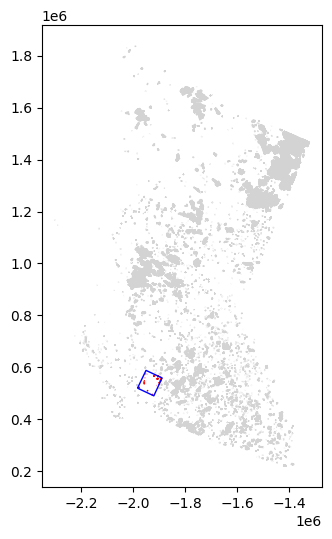

In [78]:
ax = BC_gdfs.plot(edgecolor="lightgrey", facecolor="none", figsize=(6, 6))
fires_in_box.plot(ax=ax, edgecolor="red", facecolor="none")
gpd.GeoSeries([rect_poly_proj], crs=BC_gdfs.crs).plot(ax=ax, edgecolor="blue", facecolor="none")


In [79]:
fires_in_box

,year,fireid,basrc,firemaps,firemapm,cause,hs_sdate,hs_edate,ag_sdate,ag_edate,...,adj_ha,adj_flag,admin_area,natpark,prescribed,version,gid,shape_length,shape_area,geometry
252,2024,249,MAFiMS,Sentinel-2,Processed imagery,Natural,2024-08-06,2024-08-16,2024-08-06,2024-11-06,...,297.731795,None,BC,None,None,20250506,2024_249,20269.695494,2.950380e+06,"MULTIPOLYGON (((-1904313.922 557640.907, -1904..."
1320,2024,1313,Agency,Aerial survey,Direct from GPS,Natural,2024-08-06,2024-08-15,2024-08-06,2024-09-17,...,71.691158,true,BC,None,None,20250506,2024_1313,4672.232583,6.640110e+05,"MULTIPOLYGON (((-1915949.167 570081.933, -1915..."
1322,2024,1315,Agency,Aerial survey,Direct from GPS,Natural,2024-08-08,2024-08-09,2024-08-05,2024-09-17,...,5.306808,true,BC,None,None,20250506,2024_1315,799.271070,4.436953e+04,"POLYGON ((-1908521.768 530011.675, -1908545.50..."
1326,2024,1319,Agency,Ground survey,Direct from GPS,Human,2024-09-05,2024-09-06,2024-09-05,2024-09-16,...,2.050693,true,BC,None,None,20250506,2024_1319,676.498497,1.654338e+04,"POLYGON ((-1977512.077 522681.710, -1977507.53..."
3349,2023,1375,Agency,Aerial survey,Direct from GPS,Human,None,None,2023-05-13,2023-06-29,...,20.777723,true,BC,None,None,20250506,2023_1375,1755.403198,1.834071e+05,"POLYGON ((-1954074.197 559915.769, -1954081.29..."
3350,2023,1376,Agency,Ground survey,Direct from GPS,Human,None,None,2023-07-04,2023-07-26,...,22.424101,true,BC,None,None,20250506,2023_1376,2134.076801,1.990855e+05,"POLYGON ((-1944729.985 510850.690, -1944719.92..."
3352,2023,1378,Agency,Ground survey,Direct from GPS,Natural,None,None,2023-07-12,2023-07-25,...,0.874648,true,BC,None,None,20250506,2023_1378,588.561204,6.795790e+03,"POLYGON ((-1898572.886 541750.937, -1898571.81..."
4703,2022,517,Agency,Ground survey,Direct from GPS,Natural,None,None,2022-09-14,None,...,2.518570,true,BC,None,None,20250506,2022_517,789.708129,2.040020e+04,"POLYGON ((-1919681.520 565736.362, -1919681.51..."
4705,2022,519,Agency,Ground survey,Direct from GPS,Human,2022-04-23,2022-04-23,2022-04-11,None,...,23.886734,true,BC,None,None,20250506,2022_519,3017.117470,2.116578e+05,"POLYGON ((-1902859.488 566491.366, -1902859.47..."
6044,2019,1140,Agency,Ground survey,Direct from GPS,Human,None,None,2019-04-01,None,...,73.224119,true,BC,None,None,20250506,2019_1140,4298.437302,6.807184e+05,"POLYGON ((-1956638.856 541097.732, -1956638.09..."
